In [1]:
from tensorflow.python.keras.layers import Input, Dense, Conv2D, Concatenate, UpSampling2D, MaxPooling2D, Lambda, Reshape
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import concatenate, merge
from tensorflow.python.keras.backend import expand_dims, squeeze
from tensorflow.python.keras.optimizers import RMSprop
from PIL import Image
import numpy as np
from tensorflow.python.keras.utils.data_utils import Sequence
import time

In [2]:
encoding_dim = 32


y_shape = (720, 1280, 1)
uv_shape = (360, 640, 1)

def normalize(im):
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            im[y, x] /= 255.0

def loadImage(num):
    img = {}

    for channel in ["y", "u", "v"]:
        img[channel] = np.array(Image.open("gaming/Gaming_720P-4813/Gaming_720P-4813_{}_{}.png".format(num,channel)))
        normalize(img[channel])
        img[channel] = np.reshape(img[channel], (img[channel].shape[0], img[channel].shape[1], 1))

    return img

def loadBaselineImage(num):
    img = {}

    for channel in ["y", "u", "v"]:
        img[channel] = np.array(Image.open("gaming_y/Gaming_720P-4813/Gaming_720P-4813_{}_{}.baseline.jpg".format(num,channel)))
        normalize(img[channel])
        img[channel] = np.reshape(img[channel], (img[channel].shape[0], img[channel].shape[1], 1))

    return img

# source_prevs = []
# source_nexts = []
# destination_nexts = []
# for i in range(2,6):
#     source_prev = loadImage("0000{}".format(i))
#     source_next = loadBaselineImage("0000{}".format(i+1))
#     destination_next = loadImage("0000{}".format(i+1))
#     source_prevs.append(source_prev)
#     source_nexts.append(source_next)
#     destination_nexts.append(destination_next)

In [3]:
# y_prev = []
# y_next = []
# u_prev = []
# u_next = []
# v_prev = []
# v_next = []
# y_out = []
# uv_out = []

# for prev, _next, dest in zip(source_prevs, source_nexts, destination_nexts):
#     y_prev.append(prev["y"])
#     y_next.append(_next["y"])
#     u_prev.append(prev["u"])
#     u_next.append(_next["u"])
#     v_prev.append(prev["v"])
#     v_next.append(_next["v"])

#     y_out.append(np.reshape(dest["y"], (720, 1280)))
#     uv_out.append(np.reshape(np.concatenate((dest["u"], dest["v"]), axis = 2), (-1, 360, 640)))

    
# model_inputs = [y_prev, y_next, u_prev, u_next, v_prev, v_next]
# model_outputs = [y_out, uv_out]

# print(dest["y"].shape)
# #print(model_outputs)

In [3]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

In [4]:
y_input = Input(y_shape)
y_emb_input = Input(y_shape)
u_input = Input(uv_shape)
u_emb_input = Input(uv_shape)
v_input = Input(uv_shape)
v_emb_input = Input(uv_shape)

y_conv1 = Conv2D(16, (3,3), padding="same", name='yConv', strides=(2, 2), activation='relu', input_shape=y_shape)(y_input) # 360x640x16
u_conv1 = Conv2D(16, (3,3), padding="same", name='uConv', activation='relu', input_shape=uv_shape)(u_input) # 360x640x16
v_conv1 = Conv2D(16, (3,3), padding="same", name='vConv', activation='relu', input_shape=uv_shape)(v_input) # 360x640x16
y_emb_conv1 = Conv2D(16, (3,3), padding="same", name='yEmbConv', strides=(2, 2), activation='relu', input_shape=y_shape)(y_input) # 360x640x16
u_emb_conv1 = Conv2D(16, (3,3), padding="same", name='uEmbConv', activation='relu', input_shape=uv_shape)(u_input) # 360x640x16
v_emb_conv1 = Conv2D(16, (3,3), padding="same", name='vEmbConv', activation='relu', input_shape=uv_shape)(v_input) # 360x640x16

conv1 = concatenate([y_conv1, y_emb_conv1, u_conv1, u_emb_conv1, v_conv1, v_emb_conv1]) # 360x640x96
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 180x320x96
conv2 = Conv2D(192, (3, 3), activation='relu', padding='same')(pool1) # 180x320x192
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) # 90x160x192
conv3 = Conv2D(384, (3, 3), activation='relu', padding='same')(pool2) # 90x160x384
conv4 = Conv2D(384, (3, 3), activation='relu', padding='same')(conv3) # 90x160x384
up1 = UpSampling2D((2,2))(conv4) # 180x320x768
conv5 = Conv2D(192, (3, 3), activation='relu', padding='same')(up1) # 180x320x192
up2 = UpSampling2D((2,2))(conv5) # 360x640x384
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) # 360x640x3

decoded_upscale = UpSampling2D(2)(decoded)
y_reshaped = Reshape((3, 720, 1280))(decoded_upscale) # 1x360x640x1
y_lambda = Lambda(lambda x: x[0, :1, :, :])(y_reshaped) # 720x1280
#y_upsample = UpSampling2D(2)(y_reshaped)
#y_conv_post = Conv2D(12, (5, 5), activation = 'relu', padding = 'same')(y_upsample)

uv_reshaped = Reshape((3, 360, 640))(decoded)
uv_lambda = Lambda(lambda x: x[:, 1:, :, :])(uv_reshaped)
#uv_reshape = expand_dims(uv_lambda, (0,))
#uv_post_conv = Conv2D(12, (5, 5), activation = 'relu', padding='same')(uv_reshape)

model = Model([y_input, y_emb_input, u_input, u_emb_input, v_input, v_emb_input], outputs=[y_lambda, uv_lambda])
model.compile(loss='mean_squared_error', optimizer = RMSprop())
model.summary()

W0615 09:56:05.390659 139987703392064 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1635: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 720, 1280, 1 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 360, 640, 1) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 360, 640, 1) 0                                            
__________________________________________________________________________________________________
yConv (Conv2D)                  (None, 360, 640, 16) 160         input_1[0][0]                    
______________________________________________________________________________________________

In [5]:
import os
def number_of_files(dir):
    list = os.listdir(dir) # dir is your directory path
    return len(list)/3
print(number_of_files("/macierz/home/149528pp/DLCVProject/gaming_y/Gaming_720P-4813"))

1199.0


In [6]:
def data_generator(num_photos_per_batch):
    files = number_of_files("/macierz/home/149528pp/DLCVProject/gaming_y/Gaming_720P-4813")
    y_prev = []
    y_next = []
    u_prev = []
    u_next = []
    v_prev = []
    v_next = []
    source_prevs = []
    source_nexts = []
    y_out = []
    uv_out = []
    destination_nexts = []
    n = 0
    while 1:
        for i in range(2,int(files)):
            n+=1
            source_prev = loadImage("%05d" % (i))
            source_next = loadBaselineImage("%05d" % (i+1))
            source_prevs.append(source_prev)
            source_nexts.append(source_next)
            destination_next = loadImage("%05d" % (i+1))
            destination_nexts.append(destination_next)
            # yield the batch data
            if n==num_photos_per_batch:
                for prev, _next, dest in zip(source_prevs, source_nexts, destination_nexts):
                    y_prev.append(prev["y"])
                    y_next.append(_next["y"])
                    u_prev.append(prev["u"])
                    u_next.append(_next["u"])
                    v_prev.append(prev["v"])
                    v_next.append(_next["v"])
                    
                    y_out.append(np.reshape(dest["y"], (720, 1280)))
                    uv_out.append(np.reshape(np.concatenate((dest["u"], dest["v"]), axis = 2), (-1, 360, 640)))
                    
                yield ([y_prev, y_next, u_prev, u_next, v_prev, v_next],[y_out, uv_out])
                y_prev, y_next, u_prev, u_next, v_prev, v_next = list(), list(), list(), list(), list(), list()
                source_prevs = []
                source_nexts = []
                y_out, uv_out = list(), list()
                destination_nexts = []
                n=0

In [ ]:
number_pics_per_batch = 3
generator = data_generator(number_pics_per_batch)

files = number_of_files("/macierz/home/149528pp/DLCVProject/gaming_y/Gaming_720P-4813")
step = files//number_pics_per_batch
history = model.fit(generator, epochs=10, steps_per_epoch=step, shuffle=False)
timestr = time.strftime("%Y%m%d-%H%M%S")
model.save_weights('model_weights/model-' + timestr +'.h5')
history_dict = history.history
print(history_dict.keys())

Epoch 1/10
  1/399 [..............................] - ETA: 2:07:26 - loss: 3.9786e-06 - lambda_loss: 3.9786e-06 - lambda_1_loss: 5.1288e-12

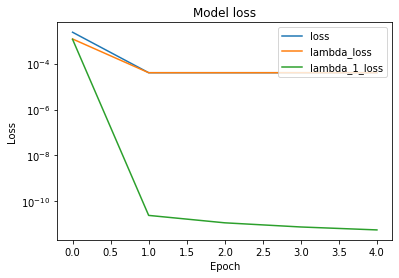

In [14]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['lambda_loss'])
plt.plot(history.history['lambda_1_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'lambda_loss','lambda_1_loss'], loc='upper right')
plt.yscale("log")
plt.show()